In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import datetime
import os
import time
import xarray as xr
from dateutil.relativedelta import relativedelta

from torch.utils.data import DataLoader

from utils import normalize

from mod_moving_mnist import ModMovingMNIST
from mpnnlstm import NextFramePredictorAR, NextFramePredictorS2S
from model import MPNNLSTMI, MPNNLSTM
from seq2seq import Seq2Seq
from ice_test import IceDataset

In [2]:
# fetch = False
# if fetch:
#     import sys 
#     sys.path.append('/Users/zach/Library/CloudStorage/OneDrive-UniversityofWaterloo/Documents/MASc/test')

#     import datetime 
#     from glorys import get_glorys

#     ds = get_glorys()
#     ds = ds.sel(latitude=slice(51, 70), longitude=slice(-95, -65))[['siconc']]
#     ds = ds.sel(time=slice(datetime.datetime(2013, 1, 1), datetime.datetime(2018, 1, 1)))
# else:
#     ds = xr.open_dataset('data/glorys.nc')

coarsen = 0

ds = xr.open_zarr('data/era5_hb_daily.zarr')

if coarsen != 0:
    ds = ds.coarsen(latitude=coarsen, longitude=coarsen, boundary='trim').mean()
    
mask = np.isnan(ds.siconc.isel(time=0)).values

/Users/zach/opt/miniconda3/envs/mpnnlstm/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [6]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Number of frames to read as input
input_timesteps = 5
output_timesteps= 30

x_vars = ['siconc', 't2m', 'v10', 'u10', 'sshf']
y_vars = ['siconc']  # ['siconc', 't2m']
training_years = range(2010, 2016)

input_features = len(x_vars)

month = 6

data_train = IceDataset(ds, training_years, month, input_timesteps, output_timesteps, x_vars, y_vars)
data_test = IceDataset(ds, [training_years[-1]+1], month, input_timesteps, output_timesteps, x_vars, y_vars)
data_val = IceDataset(ds, [training_years[-1]+2], month, input_timesteps, output_timesteps, x_vars, y_vars)

loader_train = DataLoader(data_train, batch_size=1, shuffle=True, collate_fn=lambda x: x[0])
loader_test = DataLoader(data_test, batch_size=1, shuffle=True, collate_fn=lambda x: x[0])
loader_val = DataLoader(data_val, batch_size=1, shuffle=True, collate_fn=lambda x: x[0])

In [8]:
input_features = len(x_vars)
thresh = 1

# Add 3 to the number of input features since we add positional encoding (x, y) and node size (s)
nn = Seq2Seq(
    hidden_size=64,
    dropout=0.1,
    thresh=thresh,
    input_features=input_features+3,
    output_timesteps=output_timesteps,
    n_layers=3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')
print('device:', device)


model = NextFramePredictorS2S(
    nn,
    thresh=thresh,
    experiment_name=str(month)+'test',
    input_features=input_features,
    output_timesteps=output_timesteps,
    device=[device])

model.model

device: cpu


Seq2Seq(
  (encoder): Encoder(
    (rnns): ModuleList(
      (0): GConvLSTM(
        (conv_x_i): GCNConv(8, 64)
        (conv_h_i): GCNConv(64, 64)
        (conv_x_f): GCNConv(8, 64)
        (conv_h_f): GCNConv(64, 64)
        (conv_x_c): GCNConv(8, 64)
        (conv_h_c): GCNConv(64, 64)
        (conv_x_o): GCNConv(8, 64)
        (conv_h_o): GCNConv(64, 64)
      )
      (1): GConvLSTM(
        (conv_x_i): GCNConv(64, 64)
        (conv_h_i): GCNConv(64, 64)
        (conv_x_f): GCNConv(64, 64)
        (conv_h_f): GCNConv(64, 64)
        (conv_x_c): GCNConv(64, 64)
        (conv_h_c): GCNConv(64, 64)
        (conv_x_o): GCNConv(64, 64)
        (conv_h_o): GCNConv(64, 64)
      )
      (2): GConvLSTM(
        (conv_x_i): GCNConv(64, 64)
        (conv_h_i): GCNConv(64, 64)
        (conv_x_f): GCNConv(64, 64)
        (conv_h_f): GCNConv(64, 64)
        (conv_x_c): GCNConv(64, 64)
        (conv_h_c): GCNConv(64, 64)
        (conv_x_o): GCNConv(64, 64)
        (conv_h_o): GCNConv(64, 64)
   

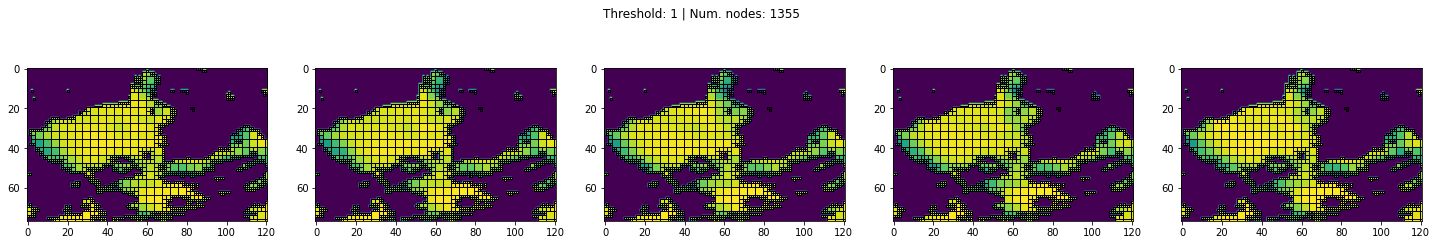

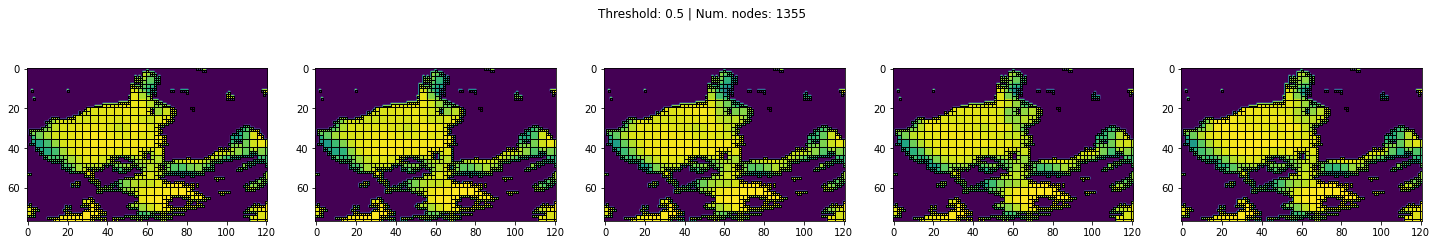

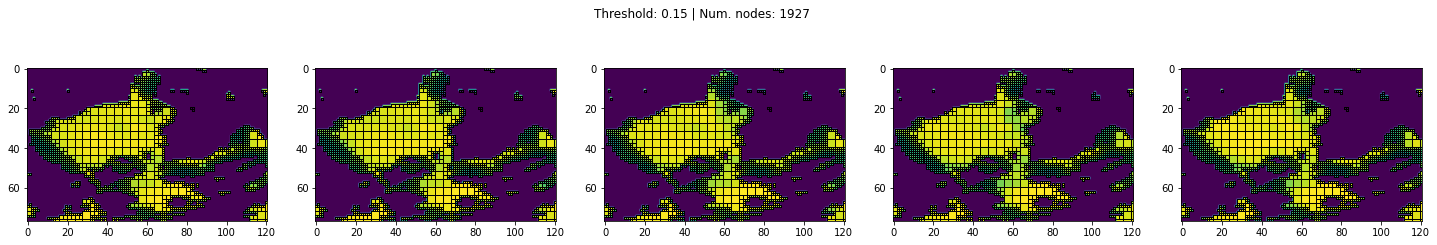

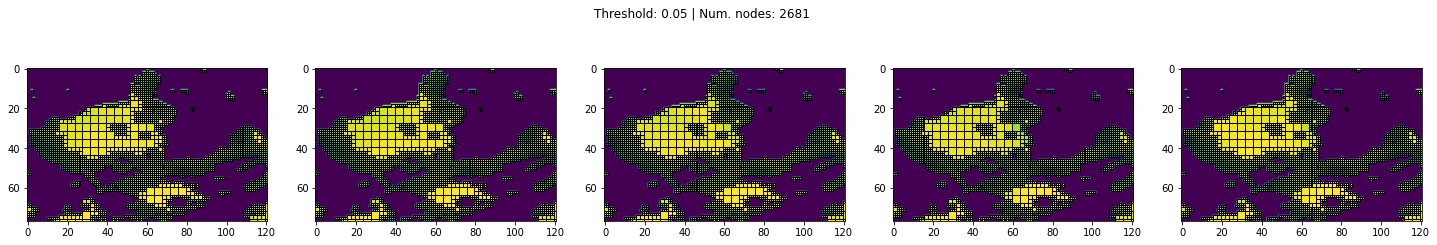

In [27]:
frame_index = 0

x_viz = loader_val.dataset.x[:10]

fig, axs = model.test_threshold(x_viz, thresh=1, frame_index=frame_index, mask=mask)
plt.show()

fig, axs = model.test_threshold(x_viz, thresh=0.5, frame_index=frame_index, mask=mask)
plt.show()

fig, axs = model.test_threshold(x_viz, thresh=0.15, frame_index=frame_index, mask=mask)
plt.show()

fig, axs = model.test_threshold(x_viz, thresh=0.05, frame_index=frame_index, mask=mask)
plt.show()

In [14]:
import cProfile
cProfile.run('model.train(x[:2], y[:2], x_test[:2], y_test[:2], lr=0.01, n_epochs=1, mask=mask)', sort=1)

  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([3806, 5])
torch.Size([3806, 5])
torch.Size([3806, 5])


 50%|█████     | 1/2 [00:07<00:07,  7.61s/it]

torch.Size([3806, 5])
torch.Size([3806, 5])
torch.Size([3806, 5])


torch.Size([3782, 5])
torch.Size([3782, 5])
torch.Size([3782, 5])
torch.Size([3803, 5])
torch.Size([3803, 5])
torch.Size([3803, 5])
Epoch 0 train MSE: 0.4670, test MSE: 0.4617, lr: 0.0100, time_per_epoch: 25.4
Finished in 0.42354798316955566 minutes
         33586329 function calls (30464066 primitive calls) in 25.489 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
1615771/1237608    4.392    0.000    8.730    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        2    2.758    1.379    2.758    1.379 {method 'run_backward' of 'torch._C._EngineBase' objects}
     6336    1.782    0.000    1.782    0.000 {method 'scatter_add_' of 'torch._C._TensorBase' objects}
2487788/29600    1.551    0.000    5.319    0.000 graph_functions.py:98(decompose)
  1849556    1.503    0.000    1.503    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      185    1.310    0.007    1.477    0.008 graph_functions.py:

In [10]:
import cProfile
loader_profile = DataLoader(data_train, batch_size=1, sampler=torch.utils.data.SubsetRandomSampler(range(1)))
cProfile.run('model.train(loader_profile, loader_profile, lr=0.01, n_epochs=1, mask=mask)', sort=1)

         7348 function calls (6136 primitive calls) in 0.004 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.001    0.001    0.001    0.001 {built-in method torch.stack}
       35    0.001    0.000    0.001    0.000 {method 'acquire' of '_thread.lock' objects}
 1042/165    0.000    0.000    0.000    0.000 module.py:1843(named_modules)
      165    0.000    0.000    0.000    0.000 module.py:1268(__setattr__)
    164/1    0.000    0.000    0.001    0.001 module.py:1888(train)
      153    0.000    0.000    0.000    0.000 module.py:1671(_named_members)
       15    0.000    0.000    0.000    0.000 socket.py:543(send)
        1    0.000    0.000    0.000    0.000 {built-in method torch._ops.profiler._record_function_enter}
      327    0.000    0.000    0.000    0.000 module.py:1795(named_children)
        1    0.000    0.000    0.000    0.000 {built-in method torch.empty}
        1    0.000    0.000    0.000    

ValueError: too many values to unpack (expected 5)

In [ ]:
model.model.device

In [9]:
model.model.train()
model.train(loader_train, loader_test, lr=0.01, n_epochs=1, mask=mask)  # Train for 20 epochs


# model.model.eval()
# model.score(x_val, y_val[:, :1])  # Check the MSE on the validation set

KeyboardInterrupt: 

<AxesSubplot: >

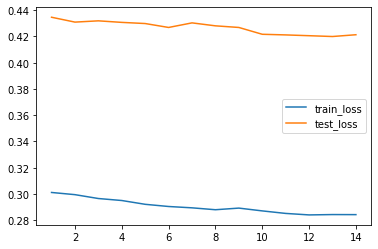

In [312]:
model.loss.iloc[1:].plot()
# model.loss.to_csv('ice_results/loss.csv')

In [313]:
launch_step = 0

# Get predictions on the validation set
model.model.eval()
y_hat = model.predict(x_val[[launch_step]], mask)

In [14]:
model.save('test_results')

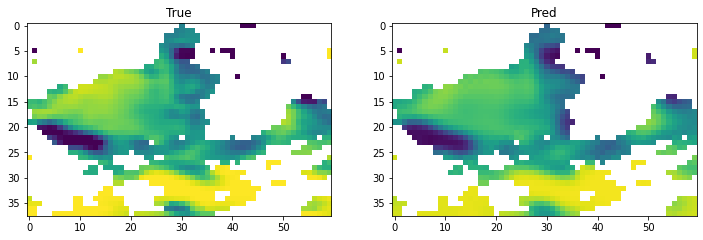

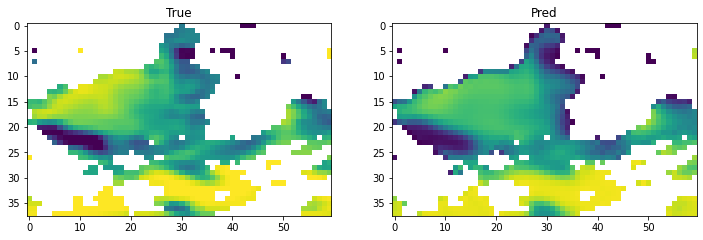

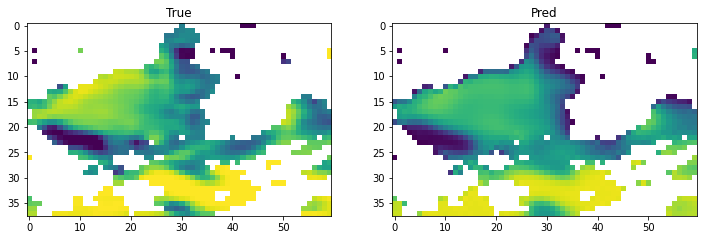

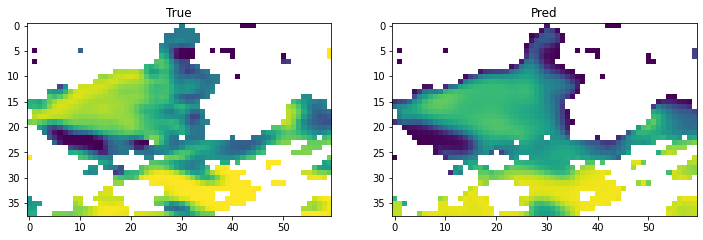

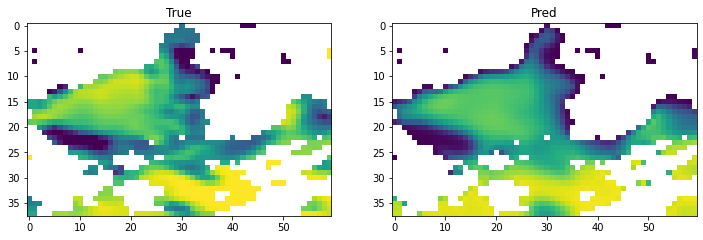

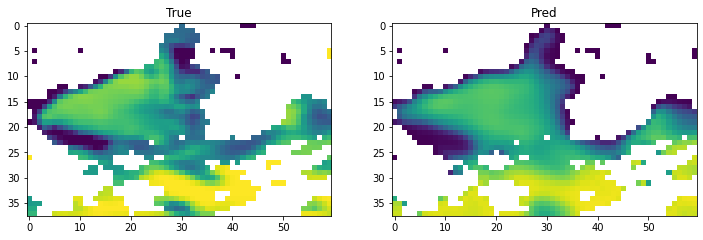

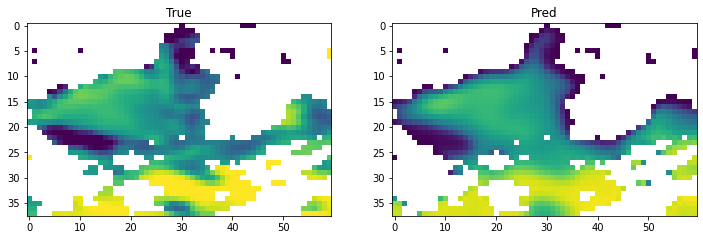

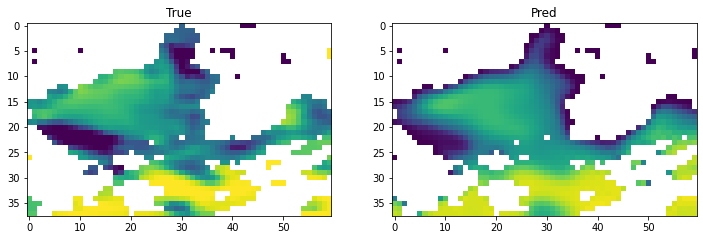

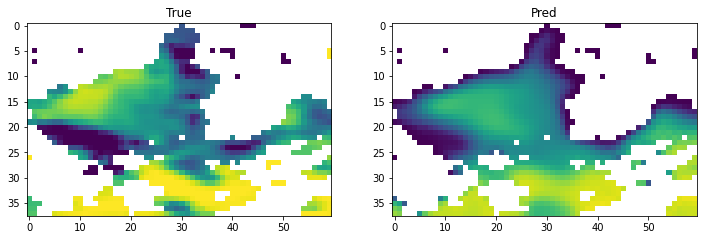

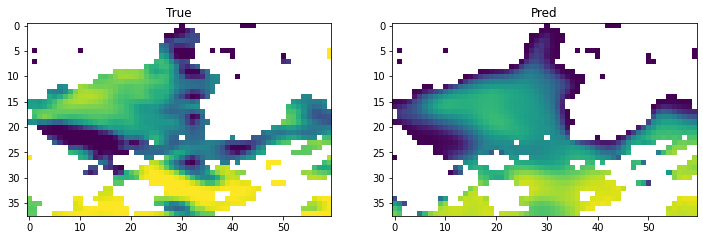

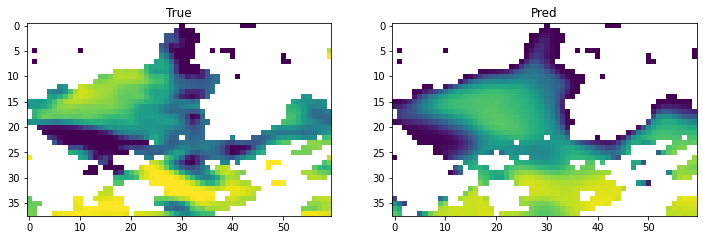

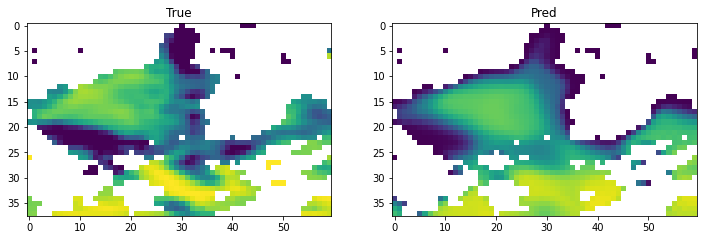

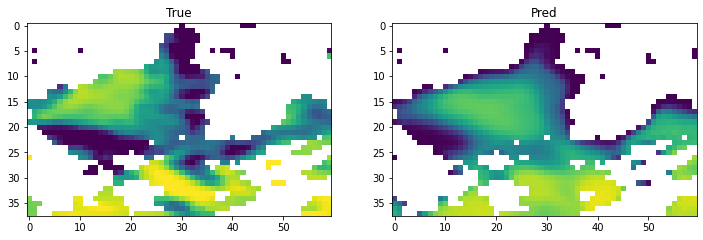

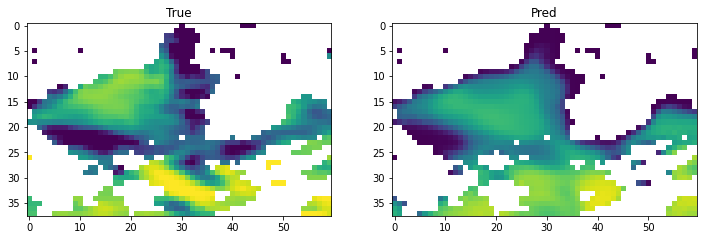

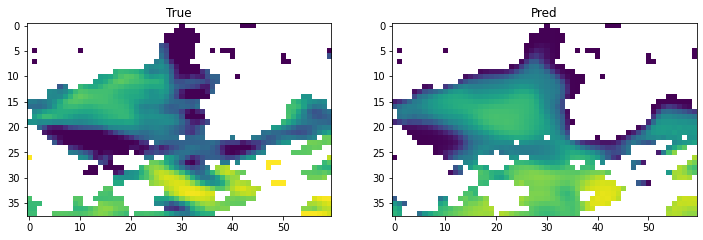

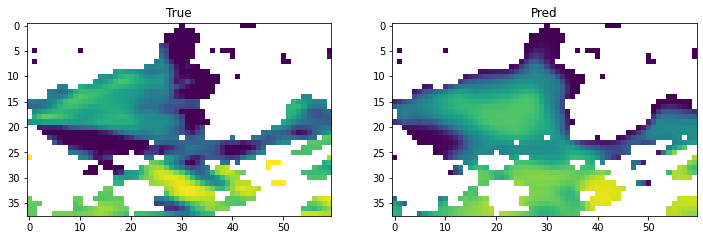

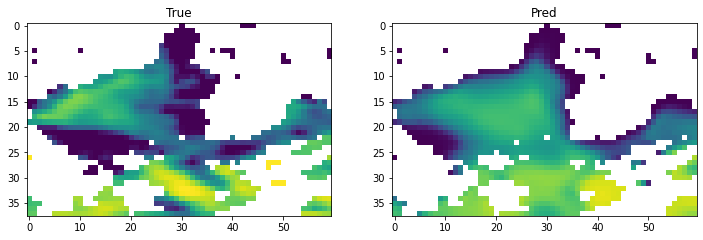

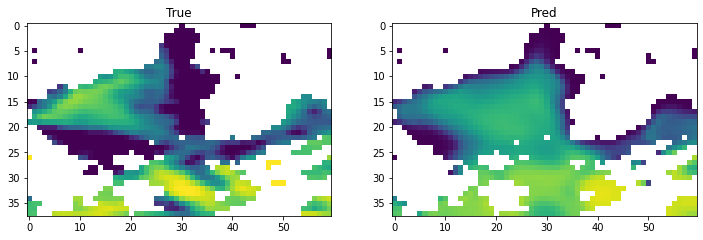

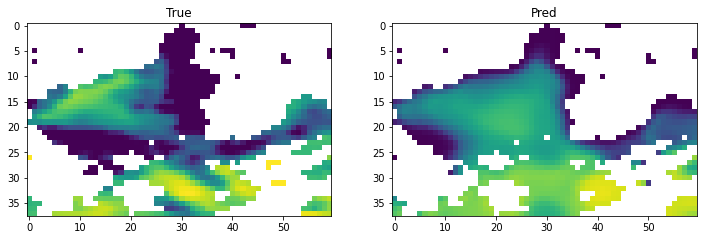

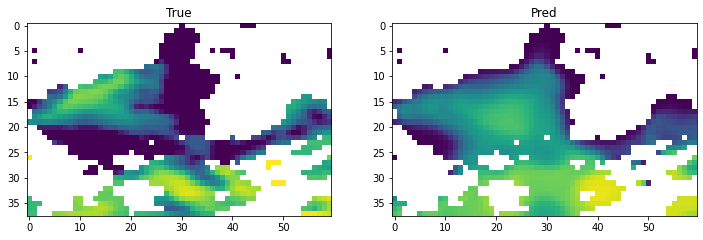

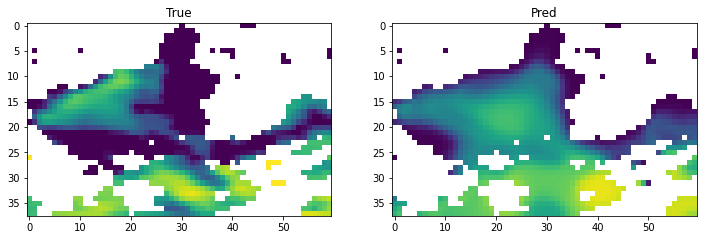

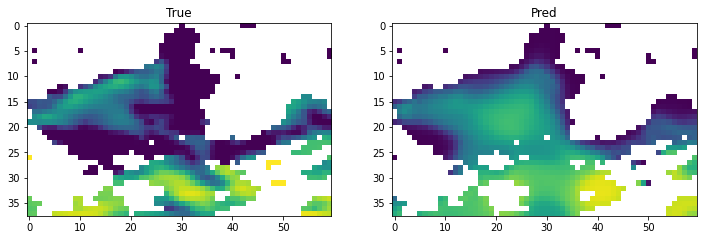

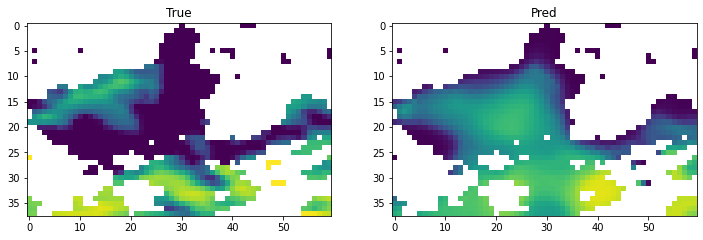

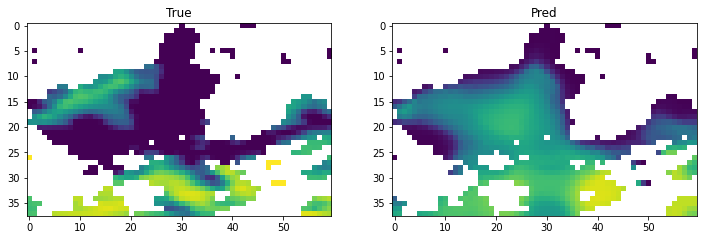

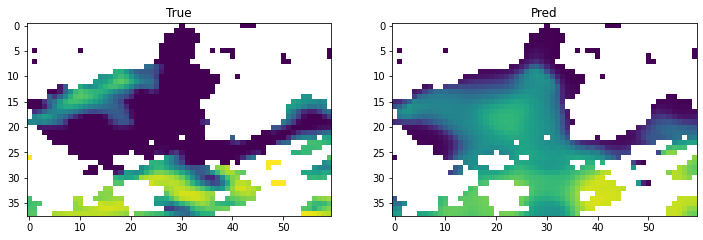

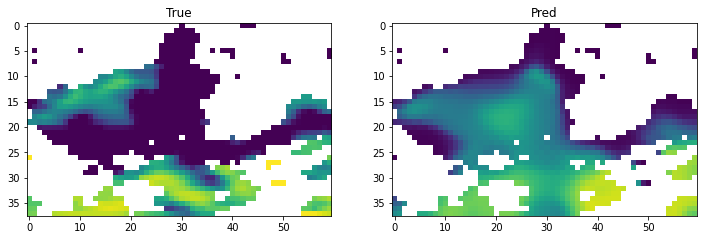

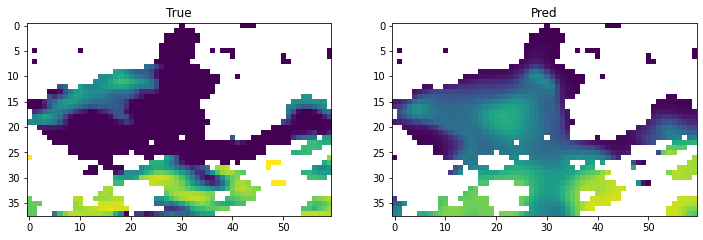

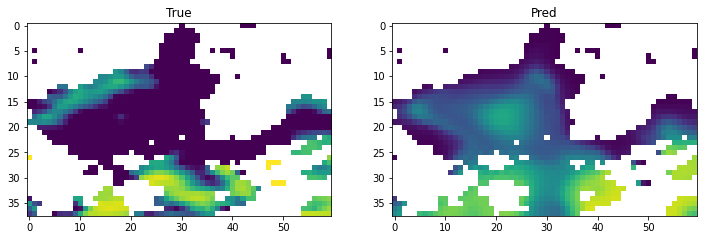

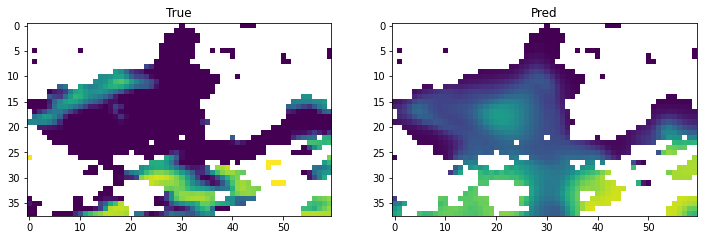

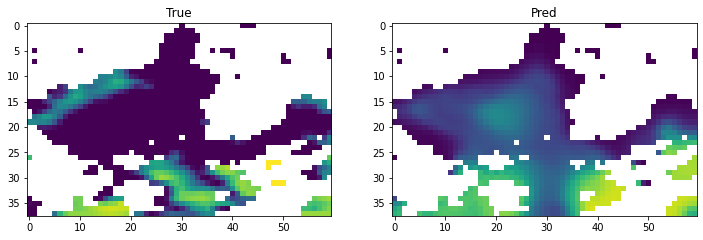

In [318]:
for i in range(output_timesteps):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    y_val_step = y_val[launch_step][i].squeeze(-1)
    y_hat_step = y_hat.squeeze(0)[i][..., 0]
    axs[0].imshow(np.where(~mask, y_val_step, np.nan), vmin=0, vmax=1)
    axs[1].imshow(np.where(~mask, y_hat_step, np.nan), vmin=0, vmax=1)
    axs[0].set_title('True')
    axs[1].set_title('Pred')
    plt.show()

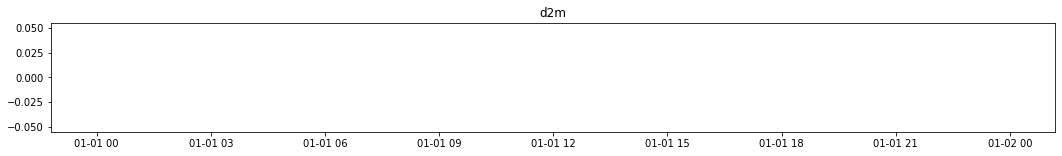

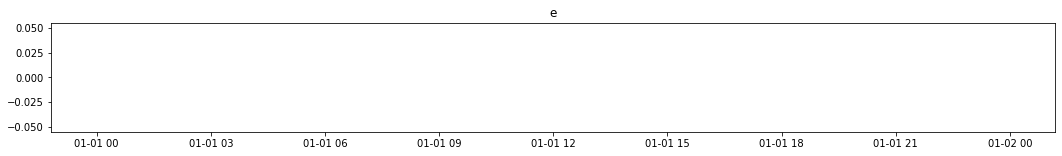

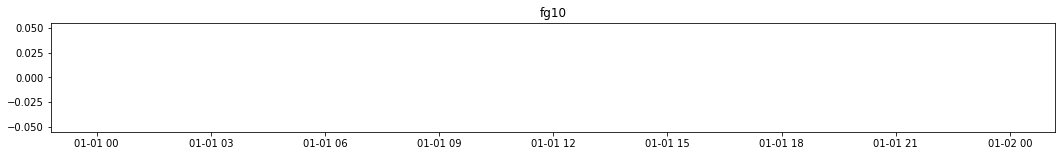

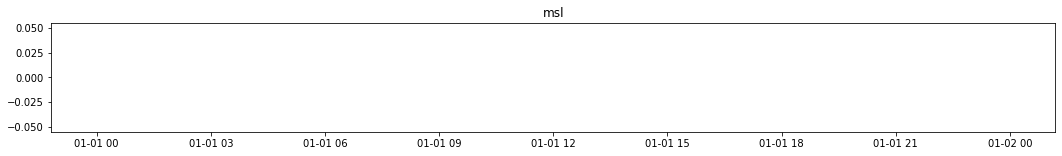

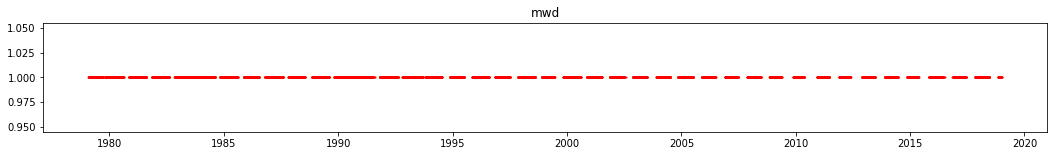

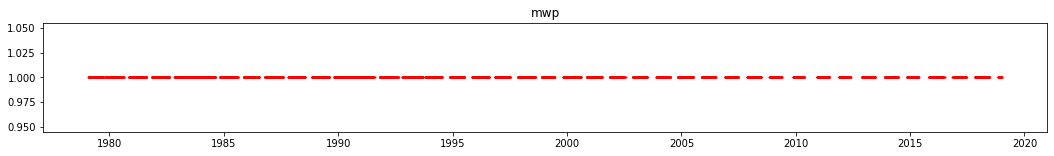

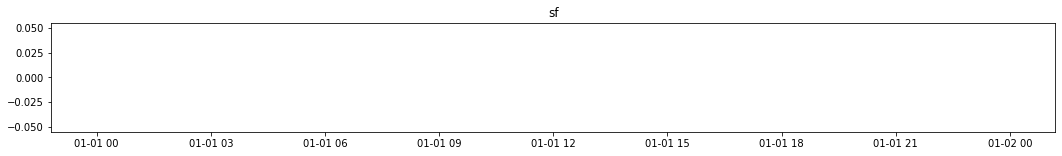

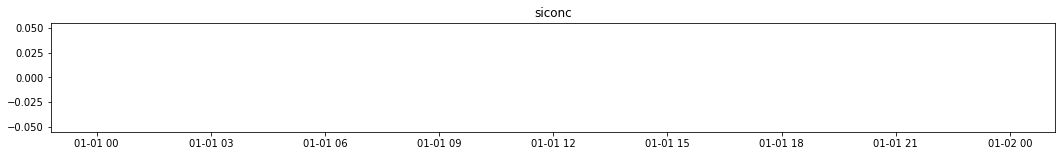

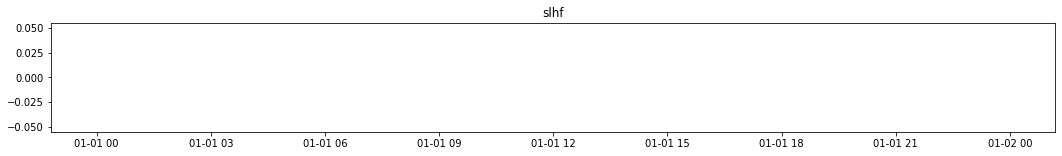

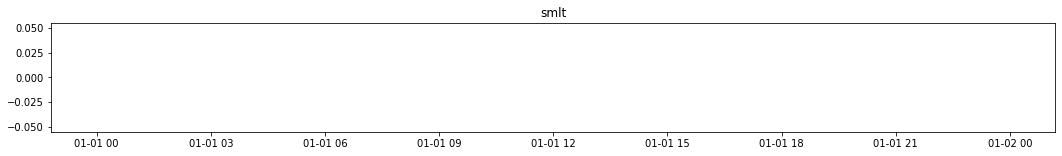

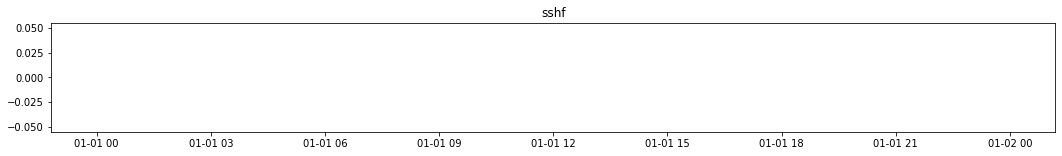

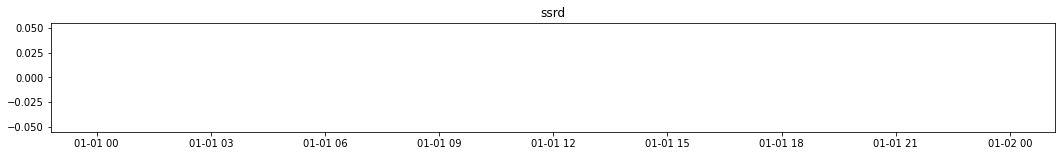

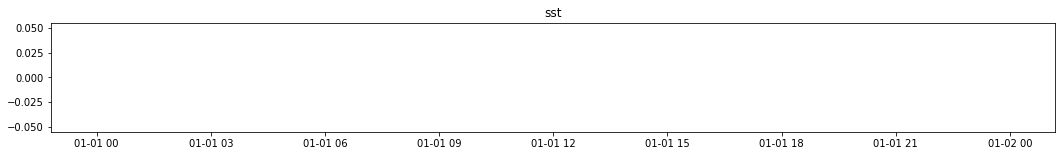

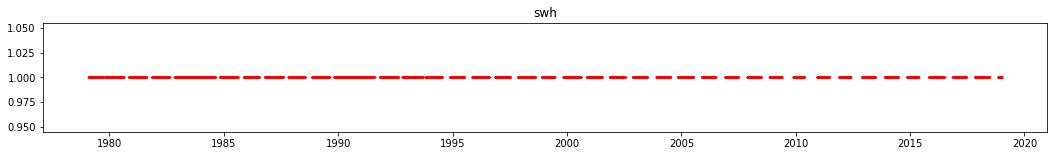

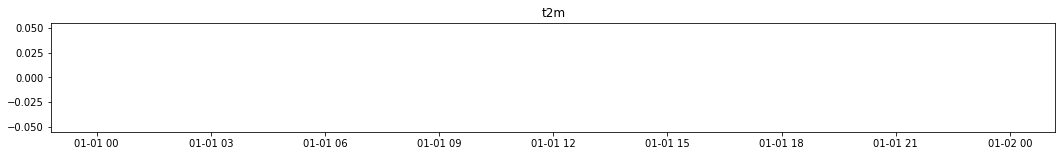

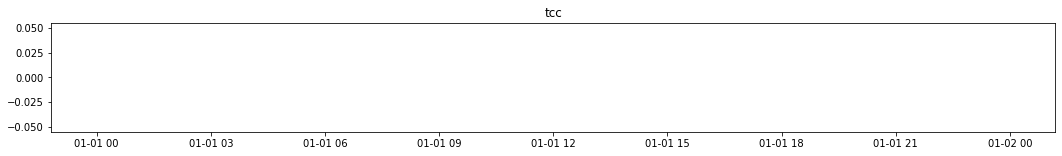

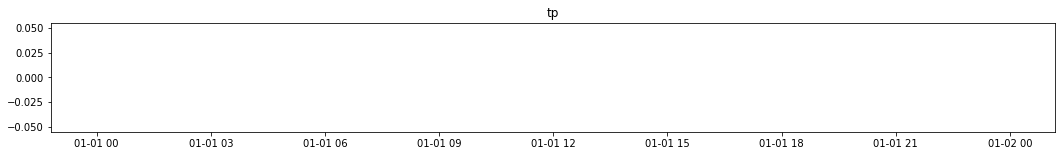

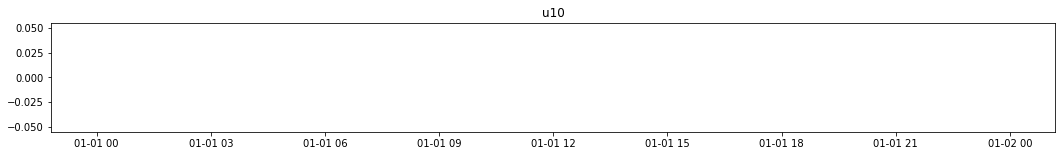

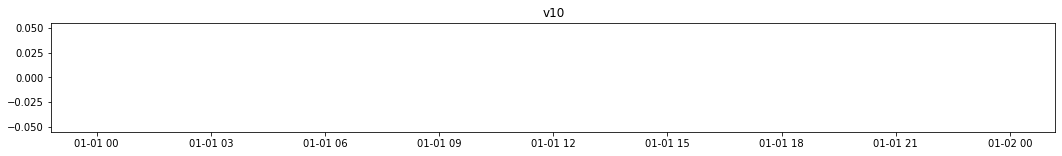

In [42]:
for d in ds.data_vars:
    plt.figure(figsize=(18, 2))
    plt.scatter(ds.time, np.where(np.isnan(ds.isel(latitude=50, longitude=50)[d]), 1, np.nan), c='r', s=1)
    plt.title(d)
    plt.show()

In [24]:
for month in months:
    x_val, y_val = xarray_to_x_y(ds,
                                 datetime.datetime(2017, month, 1),
                                 datetime.datetime(2017, month+1, 1), 
                                 input_timesteps,
                                 output_timesteps, 
                                 x_vars=x_vars,
                                 y_vars=y_vars)


    datetime.datetime(2017, month, 1), datetime.datetime(2017, month+1, 1)
    model.load('test_results/6test.pth')
    y_hat = model.predict(x_val)
    
    break

In [306]:
input_features = len(x_vars)

# Add 3 to the number of input features since we add positional encoding (x, y) and node size (s)
nn = MPNNLSTM(
    hidden_size=64,
    dropout=0.1,
    input_timesteps=input_timesteps,
    input_features=input_features+3,
    output_features=input_features).float()
    
model = NextFramePredictorAR(nn, experiment_name='full', decompose=True, input_features=input_features, multi_step_loss=output_timesteps)
print(model.get_n_params())
model.model

146690


MPNNLSTM(
  (convolution1): GCNConv(5, 64)
  (convolution2): GCNConv(64, 64)
  (convolution3): GCNConv(64, 64)
  (bn1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (bn2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (bn3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (recurrents): LSTM(64, 64, num_layers=4)
  (lin1): Linear(in_features=67, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)